# SMI Daily Close and Biggest Weekly Drops

This notebook loads the SMI daily data CSV (from Yahoo Finance) and visualizes the daily close.
It also computes the 5 biggest weekly drops and highlights them on the chart.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

CSV_PATH = Path('data/smi_yahoo_daily.csv')

if not CSV_PATH.exists():
    raise FileNotFoundError(
        f'CSV not found: {CSV_PATH}. Run scripts/4_download_smi_yahoo.py first.'
    )

df = pd.read_csv(CSV_PATH)
df['Date'] = pd.to_datetime(df['Date'])
# Coerce price columns to numeric in case they were parsed as strings
price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for col in price_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.sort_values('Date')
df.head()


,Date,Adj Close,Close,High,Low,Open,Volume
1,2005-01-03,5768.700195,5768.700195,5778.200195,5709.500000,5710.399902,30966000.0
2,2005-01-04,5775.500000,5775.500000,5775.500000,5750.399902,5754.299805,40011600.0
3,2005-01-05,5725.500000,5725.500000,5751.899902,5720.500000,5738.100098,43657400.0
4,2005-01-06,5742.399902,5742.399902,5757.399902,5720.500000,5724.000000,31963000.0
5,2005-01-07,5735.200195,5735.200195,5738.200195,5703.700195,5725.200195,36234800.0


In [2]:
# Compute weekly close (Friday) and weekly returns
weekly = (
    df.set_index('Date')['Close']
      .resample('W-FRI')
      .last()
      .dropna()
)
weekly_returns = weekly.pct_change().dropna()
worst_5 = weekly_returns.nsmallest(5)
worst_5


Date
2008-10-10   -0.222767
2020-03-13   -0.140627
2015-01-16   -0.132457
2008-11-21   -0.118382
2020-02-28   -0.115181
Name: Close, dtype: float64

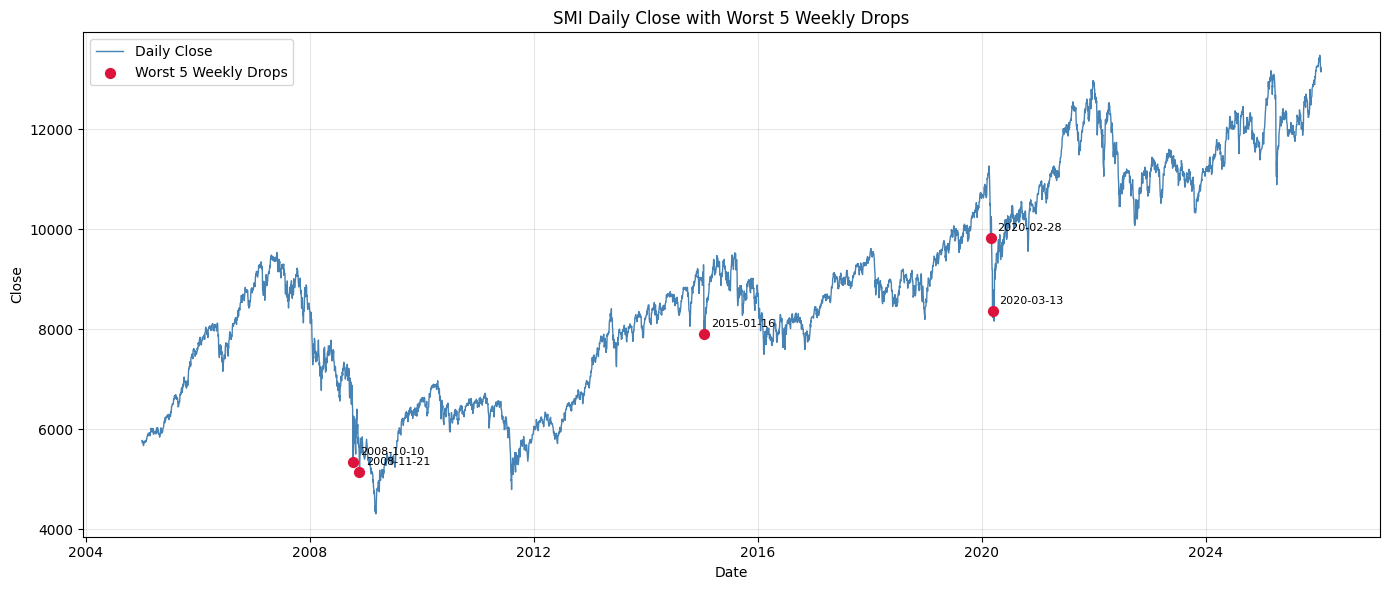

In [3]:
# Plot daily close with weekly drop markers
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], color='steelblue', linewidth=1, label='Daily Close')

# Mark worst weekly drops on the corresponding week-end date
marker_dates = worst_5.index
marker_values = df.set_index('Date').loc[marker_dates, 'Close']
plt.scatter(marker_dates, marker_values, color='crimson', s=50, zorder=3, label='Worst 5 Weekly Drops')

for d, v in zip(marker_dates, marker_values):
    plt.annotate(d.strftime('%Y-%m-%d'), (d, v), textcoords='offset points', xytext=(5, 5), fontsize=8)

plt.title('SMI Daily Close with Worst 5 Weekly Drops')
plt.xlabel('Date')
plt.ylabel('Close')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
# List the worst weekly drops
worst_5_table = worst_5.to_frame(name='Weekly Return')
worst_5_table.index.name = 'Week Ending (Fri)'
worst_5_table['Weekly Return'] = (worst_5_table['Weekly Return'] * 100).round(2)
display(worst_5_table)


,Weekly Return
Week Ending (Fri),
2008-10-10,-22.28
2020-03-13,-14.06
2015-01-16,-13.25
2008-11-21,-11.84
2020-02-28,-11.52


In [5]:
from modules.bertopic_mpnet_topics import get_top_topic_docs_for_timerange
from modules.notebook_helpers import display_search_results

for week_end, ret in worst_5.items():
    week_end = pd.to_datetime(week_end)
    week_start = week_end - pd.Timedelta(days=6)
    print(f'\nWeek {week_start.date()} to {week_end.date()} (return {ret:.2%})')
    docs = get_top_topic_docs_for_timerange(
        timerange_start=str(week_start.date()),
        timerange_end=str(week_end.date()),
        min_topic_count=5,
        min_probability=0.9,
    )
    print(docs)
    #display_search_results(docs, max_content_chars=800)


Topics with P(lambda1 > lambda0 + delta) >= 0.9 for 2020-02-22 to 2020-02-28 vs prior history:
[{'teletext_id': 'cdbd3ea9-889f-4d87-91c6-6d9242fddb6d', 'chunk_id': None, 'chunk_text': None, 'title': 'Trauerfeier für Kobe Bryant', 'content': "Tausende Menschen haben in Los Angeles an einer Gedenkveranstaltung Abschied von Kobe Bryant genommen. Der ehemalige Basketballspieler war vor knapp einem Monat bei einem Helikopterabsturz zusammen mit seiner 13-jährigen Tochter ums Leben gekommen.\r\n\r\nAn der Veranstaltung im Staples Center, das 20'000 Menschen Platz bietet, nahm auch die Basketball-Legende Michael Jordan teil. Bryants Witwe Vanessa erinnerte in einer Ansprache an ihre Tochter und ihren Ehemann.\r\n\r\nAm Montag hatte sie eine Klage gegen die Betreiberfirma des Helikopters eingereicht. Diesem wirft sie unter anderem vor, sie habe die Wetterverhältnisse nicht richtig eingeschätzt.", 'publication_datetime': datetime.datetime(2020, 2, 25, 1, 42, tzinfo=datetime.timezone.utc), 'fts_